In [2]:
import numpy as np
import re
import networkx as nx
import random
import matplotlib.pyplot as plt
import os
import glob
from ALB_instance_tools import *
import copy

In [2]:
def parse_alb(alb_file_name):
    '''Reads assembly line balancing instance .alb file, returns dictionary with the information'''
    parse_dict = {}
    alb_file = open(alb_file_name).read()
    #Get number of tasks
    num_tasks = re.search('<number of tasks>\n(\d*)', alb_file)
    parse_dict['num_tasks'] = int(num_tasks.group(1))
    
    #Get cycle time
    cycle_time = re.search('<cycle time>\n(\d*)', alb_file)
    parse_dict['cycle_time'] = int(cycle_time.group(1))
    
    #Order Strength
    order_strength= re.search('<order strength>\n(\d*,\d*)', alb_file)
    parse_dict['order_strength'] = float(order_strength.group(1).replace(',','.'))
    
    #Task_times 
    task_times = re.search('<task times>(.|\n)+?<', alb_file)
    #Get lines in this regex ignoring the first and last 2
    task_times = task_times.group(0).split('\n')[1:-2]
    task_times = {task.split()[0]:int(task.split()[1]) for task in task_times}
    parse_dict['task_times'] = task_times
   
    #Precedence relations
    precedence_relations = re.search('<precedence relations>(.|\n)+?<', alb_file)
    precedence_relations = precedence_relations.group(0).split('\n')[1:-2]
    precedence_relations = [task.split(',') for task in precedence_relations]
    parse_dict['precedence_relations'] = precedence_relations
    return parse_dict

In [19]:
instance_path = "SALBP_benchmark/small data set_n=20/instance_n=20_1.alb"

instance = parse_alb(instance_path)
instance2 = parse_alb('SALBP_benchmark/small data set_n=20/instance_n=20_2.alb')
instance['precedence_relations'] = eliminate_tasks(instance)
instance2['precedence_relations'] = eliminate_tasks(instance2)

In [28]:
instance['precedence_relations']

OutEdgeView([('1', '6'), ('6', '18'), ('4', '8'), ('8', '12'), ('11', '18'), ('12', '14'), ('12', '19'), ('14', '20')])

In [29]:
instance2['precedence_relations']

[['1', '13'],
 ['2', '5'],
 ['4', '6'],
 ['5', '10'],
 ['5', '11'],
 ['5', '12'],
 ['6', '7'],
 ['6', '8'],
 ['6', '9'],
 ['7', '13'],
 ['8', '13'],
 ['9', '13'],
 ['10', '16'],
 ['11', '14'],
 ['12', '15'],
 ['13', '17'],
 ['13', '18'],
 ['13', '19'],
 ['13', '20']]

/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_42092/3243902588.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


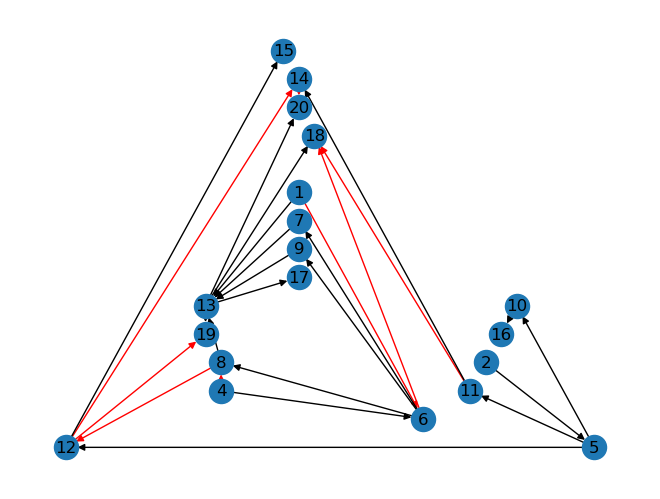

In [35]:

p_graph = nx.DiGraph()
p_graph.add_edges_from(instance['precedence_relations'], color = 'r')
p_graph.add_edges_from(instance2['precedence_relations'], color= 'k')
colors = [p_graph[u][v]['color'] for u,v in p_graph.edges]
nx.draw_planar(p_graph, edge_color=colors, with_labels=True)
plt.tight_layout()
plt.savefig("precedence_graph.png", format="PNG" )

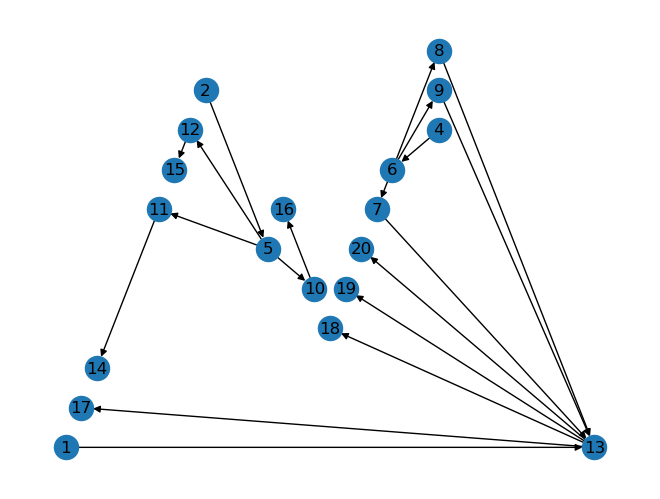

In [11]:

p_graph2 = nx.DiGraph()
p_graph2.add_edges_from(instance2['precedence_relations'])
nx.draw_planar(p_graph2, with_labels=True)

In [ ]:


def generate_equipment(number_of_pieces, number_of_stations, cost_range=[100,300], seed=None):
    rng = np.random.default_rng(seed=seed)
    equipment_cost_matrix = generate_equipment_cost(number_of_pieces, number_of_stations,rng,  cost_range)
    r_oe_matrix = generate_r_oe(equipment_cost_matrix,number_of_pieces, number_of_stations,rng)
    return equipment_cost_matrix, r_oe_matrix

def generate_r_oe(equipment_cost_matrix,number_of_pieces, number_of_stations, rng):
    mean_cost = equipment_cost_matrix.mean()
    equip_avg = equipment_cost_matrix.mean(1)
    equip_val = equip_avg/mean_cost
    #Equipment works for task with probability based on its relative cost
    #TODO make sure that this calculation is correct, equipment that are
    #when equipment is above average cost, it works for all stations
    #In case paper was wrong, this compares the sum of the equipment cost, 
    #not the average, has problem that it sometimes generates infeasible
    #r_oes
    # equip_val = equipment_cost_matrix.sum(1)/equipment_cost_matrix.sum()
    random_matrix = rng.random((number_of_pieces,number_of_stations))

    r_oe = random_matrix < equip_val.reshape(-1,1)
    return r_oe

def generate_equipment_cost(number_of_pieces, number_of_stations,rng,  cost_range=[200,300]):
    equipment_cost_matrix = rng.integers(low= cost_range[0], high=cost_range[1], size=(number_of_pieces,number_of_stations))
    return equipment_cost_matrix

In [ ]:
equipment_costs, r_oe = generate_equipment(2,3, seed=42)
print("equipment_costs", equipment_costs)
print("r_oe", r_oe)

equipment_costs [[117 254 230]
 [187 186 271]]
r_oe [[ True  True False]
 [ True  True  True]]


The below function randomly changes the precedence graph of the original instance. It will keep on trying until it generates a graph without any simple cycles.

[('6', '10'),
 ('2', '7'),
 ('7', '11'),
 ('4', '8'),
 ('4', '1'),
 ('8', '12'),
 ('5', '9'),
 ('5', '18'),
 ('10', '13'),
 ('13', '17'),
 ('13', '18'),
 ('13', '5'),
 ('14', '20'),
 ('15', '19'),
 ('15', '5'),
 ('19', '11')]

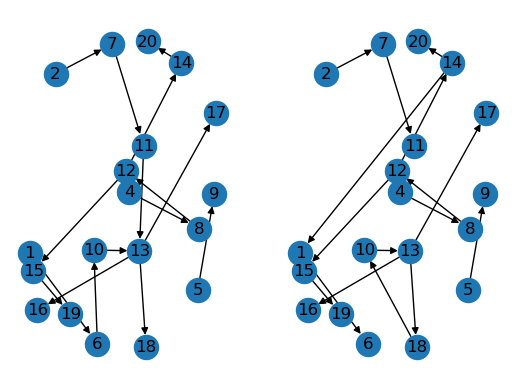

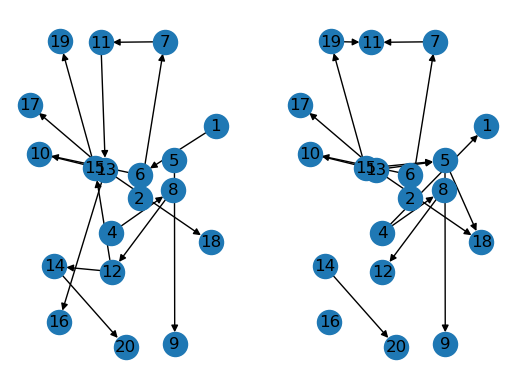

In [ ]:

def rand_pert_precedence(p_graph_orig, seed= None):
    #randomly change at least 1 edge in the precedence graph
    #Seed random number generators
    while(True):
        p_graph = p_graph_orig.copy()
        random.seed(seed)
        rng = np.random.default_rng(seed = seed)
        #calculate number of edges to change
        num_edges = 1 +  rng.poisson(lam=4)
       # nx.swap.directed_edge_swap( p_graph, nswap=num_edges, seed=seed)
        edges_to_remove = random.sample(list(p_graph.edges()), num_edges)
        edges_to_add = random.sample(list(nx.non_edges(p_graph)), num_edges)
        for index, edge in enumerate(edges_to_remove):
            p_graph.remove_edge(edge[0], edge[1])
            p_graph.add_edge(edges_to_add[index][0], edges_to_add[index][1])
        pos = nx.spring_layout(p_graph_orig, k=1)
        fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
        #nx.draw(p_graph_orig, ax=ax1, pos= pos, with_labels=True)
        #nx.draw(p_graph, ax=ax2, pos=pos, with_labels=True)
        simple_cycles =  list(nx.simple_cycles(p_graph))
        if not simple_cycles:
            return(list(p_graph.edges()))

rand_pert_precedence(p_graph)

In [ ]:
def eliminate_tasks(instance, elim_interval=(.40,.60), seed=None):
    #this function creates a second model for a given instance with lower task times
    p_graph = nx.DiGraph()
    p_graph.add_edges_from(instance['precedence_relations'])
    #nx.draw_planar(p_graph, with_labels=True)
    rng = np.random.default_rng(seed = seed)
    interval_choice = rng.uniform(low=elim_interval[0], high=elim_interval[1])
    to_remove = rng.choice(p_graph.nodes,size=(int(instance['num_tasks']*(interval_choice))), replace=False)
    for node in to_remove:
        for parent in p_graph.predecessors(node):
            for child in p_graph.successors(node):
                p_graph.add_edge(parent, child)
        p_graph.remove_node(node)
    return(p_graph.edges)

def change_task_times(instance, perc_reduct_interval = (.40,.60), seed=None):
    #this function creates new task times based on the original task times takes original task times and how much they need to be reduced
    new_task_times = instance['task_times']
    print('old task times', new_task_times)
    rng = np.random.default_rng(seed = seed)
    for key in new_task_times:
        new_task_times[key] = int(new_task_times[key] * rng.uniform(low=perc_reduct_interval[0], high=perc_reduct_interval[1]))
    print(new_task_times)
    return(new_task_times)

new_tasks = eliminate_tasks(instance,(.4,.6))
new_task_times = change_task_times(instance)
print(new_tasks)

old task times {'1': 663, '2': 349, '3': 1407, '4': 1772, '5': 403, '6': 1071, '7': 349, '8': 544, '9': 1505, '10': 700, '11': 879, '12': 1464, '13': 769, '14': 745, '15': 403, '16': 916, '17': 779, '18': 2846, '19': 876, '20': 965}
{'1': 274, '2': 176, '3': 664, '4': 876, '5': 184, '6': 580, '7': 203, '8': 296, '9': 669, '10': 291, '11': 421, '12': 730, '13': 427, '14': 410, '15': 211, '16': 385, '17': 416, '18': 1486, '19': 518, '20': 453}
[('6', '13'), ('2', '13'), ('8', '12'), ('5', '9'), ('12', '20'), ('13', '16'), ('13', '17'), ('13', '18')]


In [ ]:
os.chdir("SALBP_benchmark")
os.chdir('small data set_n=20')

FileNotFoundError: [Errno 2] No such file or directory: 'SALBP_benchmark'

In [ ]:
! pwd

/Users/letshopethisworks2/Documents/Phd Paper material/MMABPWW/SALBP_benchmark/small data set_n=20


In [ ]:
size_pair = 2

def create_instance_pairs(instance_names, size_pair = 2):
    instance_pairs = []
    instance_groups = [instance_names[i:i+size_pair] for i in range(0,len(instance_names),2)]
    for instances in instance_groups:
        parsed_instances = []
        for index, instance in enumerate(instances):
            parsed_instance= parse_alb(instance)
            parsed_instance['model_no'] = index
            parsed_instances.append(parsed_instance)
        instance_pairs.append(parsed_instances)
    return instance_pairs
instance_pairs = create_instance_pairs(list(glob.glob("*.alb")))

AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
os.listdir()

['instance_n=20_249.alb',
 'instance_n=20_261.alb',
 'instance_n=20_507.alb',
 'instance_n=20_513.alb',
 'instance_n=20_275.alb',
 'instance_n=20_117.alb',
 'instance_n=20_103.alb',
 'instance_n=20_498.alb',
 'instance_n=20_329.alb',
 'instance_n=20_315.alb',
 'instance_n=20_473.alb',
 'instance_n=20_12.alb',
 'instance_n=20_467.alb',
 'instance_n=20_301.alb',
 'instance_n=20_466.alb',
 'instance_n=20_300.alb',
 'instance_n=20_314.alb',
 'instance_n=20_13.alb',
 'instance_n=20_472.alb',
 'instance_n=20_328.alb',
 'instance_n=20_499.alb',
 'instance_n=20_102.alb',
 'instance_n=20_116.alb',
 'instance_n=20_512.alb',
 'instance_n=20_274.alb',
 'instance_n=20_260.alb',
 'instance_n=20_506.alb',
 'instance_n=20_248.alb',
 'instance_n=20_289.alb',
 'instance_n=20_276.alb',
 'instance_n=20_510.alb',
 'instance_n=20_504.alb',
 'instance_n=20_262.alb',
 'instance_n=20_128.alb',
 'instance_n=20_100.alb',
 'instance_n=20_114.alb',
 'instance_n=20_458.alb',
 'instance_n=20_39.alb',
 'instance_n=20

In [ ]:
rng = np.random.default_rng(seed = 1)

In [ ]:
rng.uniform()

0.5118216247002567

In [ ]:
rng.uniform()

0.9504636963259353

In [10]:
tasks = [1,2,3,4,5]
#Function that creates all possible partitions of tasks for n machines
def task_partition(tasks, n):
    if n == 1:
        return [tasks]
    else:
        partitions = []
        for i in range(1,len(tasks)):
            for partition in task_partition(tasks[i:], n-1):
                partitions.append([tasks[:i]] + partition)
        return partitions
    
task_partition(tasks, 3)

[[[1], [2], 3, 4, 5],
 [[1], [2, 3], 4, 5],
 [[1], [2, 3, 4], 5],
 [[1, 2], [3], 4, 5],
 [[1, 2], [3, 4], 5],
 [[1, 2, 3], [4], 5]]

In [15]:

tasks = list(range(0,10))
partitions= []
no_stations = 5
task_partitioning(partitions, [[] for _ in range(no_stations)], tasks, no_stations)
print(len(partitions))

KeyboardInterrupt: 

[[], []]

In [ ]:
#pops the first element from the list
def pop_first_element(list):
    list.pop(0)
    return list